In [76]:
import numpy as np
from numpy import sin, cos

from itertools import product
import matplotlib.pyplot as plt

def stiffness_armor(E, A, L):
    k = E * A / L * np.array([[1, -1], [-1, 1]])
    return k

def stiffness_beam(E, I, L, c=1):
    k = E*I * np.array([
        [ 12/L**3,  6/L**2, -12/L**3,  6/L**2],
        [  6/L**2,  4/L   ,  -6/L**2,  2/L   ],
        [-12/L**3, -6/L**2,  12/L**3, -6/L**2],
        [  6/L**2,  2/L   ,  -6/L**2,  4/L   ]  
    ])
    # positivo antihorario
    return k
    
def stiffness_2d(E, A, I, L, c=1):
    k = np.zeros((6,6))

    k[*np.meshgrid([0,3], [0,3])] = stiffness_armor(E, A, L)
    k[*np.meshgrid([1,2,4,5], [1,2,4,5])] = stiffness_beam(E, I, L, c)

    return k

def rot_armor(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha)],
        [-sin(alpha), cos(alpha)]
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_2d(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha), 0],
        [-sin(alpha), cos(alpha), 0],
        [          0,          0, 1]
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_armor(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha)],
        [-sin(alpha), cos(alpha) ],
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_beam(alpha):
    t = np.array([
        [cos(alpha), 0],
        [0         , 1],
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def plot_vectors(vectors, ax=None, margin=0.1):
    """
    Plot vectors from a given matrix.

    Parameters:
    - vectors: numpy array of shape (n, 2, 2)
        Matrix representing n vectors, where each vector is defined by its start and end points.
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to plot the vectors. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the vectors are plotted.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for vector in vectors:
        start_point, end_point = vector[0], vector[1]
        ax.quiver(start_point[0], start_point[1], end_point[0] - start_point[0], end_point[1] - start_point[1], angles='xy', scale_units='xy', scale=1, color='b')

    ax.set_aspect('equal', 'box')
    x_min = vectors[:,:,0].min() - margin
    x_max = vectors[:,:,0].max() + margin
    y_min = vectors[:,:,1].min() - margin
    y_max = vectors[:,:,1].max() + margin
    ax.set_xlim([min(x_min, 0), x_max])
    ax.set_ylim([min(y_min, 0), y_max])
    #ax.set_xlim([min(vectors[:,:,0].min(), 0), max(vectors[:,:,0].max(), 0)])
    #ax.set_ylim([min(vectors[:,:,1].min(), 0), max(vectors[:,:,1].max(), 0)])
    ax.grid(False)
    ax.set_axis_off()
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Vectors Plot')

    return ax
import matplotlib.pyplot as plt

def draw_points(coordinates, ax=None):
    """
    Draw points on a plot and label them with their coordinates.

    Parameters:
    - coordinates: numpy array of shape (n, 2)
        Array representing n points, where each point is defined by its x and y coordinates.
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to draw the points. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the points are drawn.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for i, (x, y) in enumerate(coordinates):
        ax.scatter(x, y, label=f'Point {i + 1}')
        ax.text(x, y, f'({x}, {y})', fontsize=8, ha='right', va='bottom')

    ax.set_aspect('equal', 'box')
    ax.grid(False)  # Desactivar la cuadrícula
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Points Plot')
    ax.legend()

    return ax

In [77]:
import numpy as np
import pandas as pd

In [78]:
#inf = np.finfo(np.float32).max
inf = 1_000_000
lit = 0.000001

In [79]:
C = np.array([
    [0,0],
    [0,4],
    [6,4],
    [0,8],
    [9,8]
])
assert np.shape(C)[1] == 2, "Las coordenadas se componen de 2 valores."

In [80]:
S = np.array([
    [0,0,0],
    [1,1,1],
    [1,1,1],
    [0,0,1],
    [0,0,0]
])
assert np.shape(S)[1] == 3, "La matriz S debe estar compuesta de 3 columnas."
assert np.shape(S)[0] == np.shape(C)[0], "La matriz S y la matriz C deben tener la misma forma."

In [81]:
B = np.array([
    [1,2],
    [2,3],
    [3,4],
    [3,5],
]) - 1
#assert np.shape(B)[1] == 2, "Las barras deben estar definidas por dos puntos"

In [82]:
EAI = np.array([
    [1, inf, 1],
    [1, inf, 1],
    [1, 1, lit],
    [1, inf, 1],
])

In [83]:
L = np.linalg.norm(np.diff(C[B], axis=1), axis=2)
with np.errstate(divide='ignore'):
    alpha = np.arctan(np.divide(*(np.diff(C[B], axis=1).squeeze().T[::-1])))
np.rad2deg(alpha)
EAIL = np.hstack([EAI, L])

In [120]:
with np.errstate(divide='ignore', ):    
    Ki = []
    A = []
    Kt = []
    for el, t in zip(EAIL, alpha):
        Ki.append(stiffness_2d(*el))
        A.append(rot_2d(t))
        Kt.append(A[-1].T @ Ki[-1] @ A[-1])
    Ki = np.array(Ki)
    A = np.array(A)
    Kt = np.array(Kt)

In [85]:
def format(value) -> str:
    #if np.abs(value) > 10000:
    #    return 'inf'
    return value.format

pd.options.display.float_format = '{:.5F}'.format

In [86]:
Kg = np.zeros(shape=(S.size,S.size))
GLg = np.zeros(shape=(S.size, 1))
_idx = np.arange(0, S.size)
G_idx = _idx.reshape(len(S), -1)[B].reshape(-1, 6)
for idx, Ki, GL in zip(G_idx, Kt, S[B]):
    Kg[*np.meshgrid(idx, idx)] += Ki
    # GLg[idx] += GL.ravel()
GLg = S.ravel()
Kg.shape, GLg.shape

((15, 15), (15,))

In [87]:
S.ravel()

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0])

In [88]:
mat = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx+1, columns=_idx+1)\
    .pipe(lambda x: x.iloc[*(np.where(S.ravel() != 0)*2)])
mat

,4,5,6,7,8,9,12
4,166666.85417,0.00000,0.37500,-166666.66667,0.00000,0.00000,0.00000
5,0.00000,250000.05556,0.16667,0.00000,-0.05556,0.16667,0.00000
6,0.37500,0.16667,1.66667,0.00000,-0.16667,0.33333,0.00000
7,-166666.66667,0.00000,0.00000,238666.82411,95999.88992,-0.19200,0.00000
8,0.00000,-0.05556,-0.16667,95999.88992,128000.13278,-0.02267,0.00000
9,0.00000,0.16667,0.33333,-0.19200,-0.02267,1.46667,0.00000
12,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [89]:
mat = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx+1, columns=_idx+1)\
    .pipe(lambda x: x.loc[(x > lit*5).any(axis=0), (x > lit*5).any(axis=1)])
mat

,4,5,6,7,8,9
4,166666.85417,0.00000,0.37500,-166666.66667,0.00000,0.00000
5,0.00000,250000.05556,0.16667,0.00000,-0.05556,0.16667
6,0.37500,0.16667,1.66667,0.00000,-0.16667,0.33333
7,-166666.66667,0.00000,0.00000,238666.82411,95999.88992,-0.19200
8,0.00000,-0.05556,-0.16667,95999.88992,128000.13278,-0.02267
9,0.00000,0.16667,0.33333,-0.19200,-0.02267,1.46667


In [90]:
np.set_printoptions(precision=3, suppress=True)
np.linalg.inv(mat.values) @ np.array([
    [0],
    [0],
    [-10],
    [8],
    [0],
    [0],
])


array([[ 29.923],
       [  0.   ],
       [-16.438],
       [ 29.923],
       [-22.442],
       [  7.306]])

In [91]:
Kgl = np.diag(GLg) @ Kg @ np.diag(GLg)

In [92]:
Q = np.zeros((7,1))
Q[2] = -10
Q[3] = 8
Q = Q.reshape(-1, 1)
Q

array([[  0.],
       [  0.],
       [-10.],
       [  8.],
       [  0.],
       [  0.],
       [  0.]])

In [93]:
d = np.linalg.inv(Kgl[np.any(Kgl, axis=0)][:, np.any(Kgl, axis=1)]) @ Q
pd.DataFrame(d, index=_idx[S.ravel() != 0]+1)

,0
4,29.92254
5,0.00000
6,-16.43800
7,29.92253
8,-22.44187
9,7.30621
12,-3.22153


In [126]:
pd.DataFrame(Ki[0])

,0,1,2,3,4,5
0,250000.00000,0.00000,0.00000,-250000.00000,0.00000,0.00000
1,0.00000,0.18750,0.37500,0.00000,-0.18750,0.37500
2,0.00000,0.37500,1.00000,0.00000,-0.37500,0.50000
3,-250000.00000,0.00000,0.00000,250000.00000,0.00000,0.00000
4,0.00000,-0.18750,-0.37500,0.00000,0.18750,-0.37500
5,0.00000,0.37500,0.50000,0.00000,-0.37500,1.00000


In [ ]:
ri = []
for i in range(len(B)):
    ri.append()

In [135]:
n = 3

dg = np.zeros(shape = (Kgl.shape[0], 1))
dg[np.where(S.ravel() != 0)] = d
K_ = np.zeros_like(Kgl)
K_[*np.meshgrid(G_idx[n], G_idx[n])] += Kt[n]
res_n = K_ @ dg
pd.DataFrame(Ki[n] @ (A[n] @ res_n[G_idx[n]]), index=np.where(res_n != 0)[0]+1)

,0
7,1849934.06016
8,-2.55740
9,-5.80900
13,-1849934.06016
14,2.55740
15,-6.97799


In [121]:
Ki[n].shape

(6, 6)

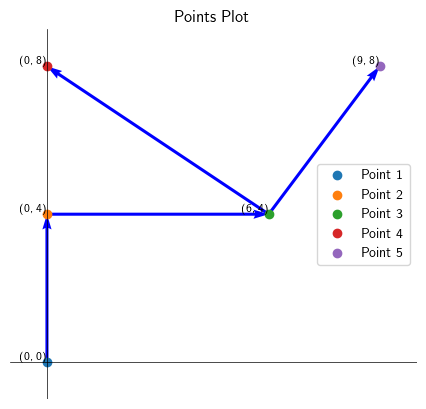

In [95]:
fig, ax = plt.subplots()
plot_vectors(C[B] ,ax=ax, margin=1)
draw_points(C, ax=ax)
plt.show()

In [96]:
def draw_gdl(C, gdl, ax=None):
    """
    Draw vectors (vertical, horizontal, and moment) based on coordinates and degrees of freedom.

    Parameters:
    - C: numpy array of shape (n, 2)
        Array representing n points, where each point is defined by its x and y coordinates.
    - gdl: numpy array of shape (n, 3)
        Array representing n degrees of freedom for each point, where each row is [vertical, horizontal, moment].
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to draw the vectors. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the vectors are drawn.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Dibujar puntos
    draw_points(C, ax)

    for i, (x, y) in enumerate(C):
        # Dibujar vector vertical
        ax.quiver(x, y, 0, gdl[i, 0], angles='xy', scale_units='xy', scale=1, color='r', label=f'Vertical {i + 1}')

        # Dibujar vector horizontal
        ax.quiver(x, y, gdl[i, 1], 0, angles='xy', scale_units='xy', scale=1, color='g', label=f'Horizontal {i + 1}')

        # Dibujar momento (vector circular)
        moment_mag = 0.1  # Magnitud del momento para visualización
        ax.quiver(x, y, -gdl[i, 2] * moment_mag, gdl[i, 2] * moment_mag, angles='xy', scale_units='xy', scale=1, color='b', label=f'Moment {i + 1}')

    ax.legend()
    return ax

In [97]:
Kk = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx + 1, columns=_idx + 1)\
    .pipe(lambda x: x.loc[(x != 0).any(axis=0), (x != 0).any(axis=1)]).values

In [98]:
Q = np.array([-28.206,
53.730,
71.639,
-16.327,
53.730,
0.000,
2.683,
53.730,
4.633,
-3.983,
])

# Fórmulas

$$ Q = q - MEF $$

* Desplazamientos
$$ d = Q \times K $$

* Momentos